### Prowizje

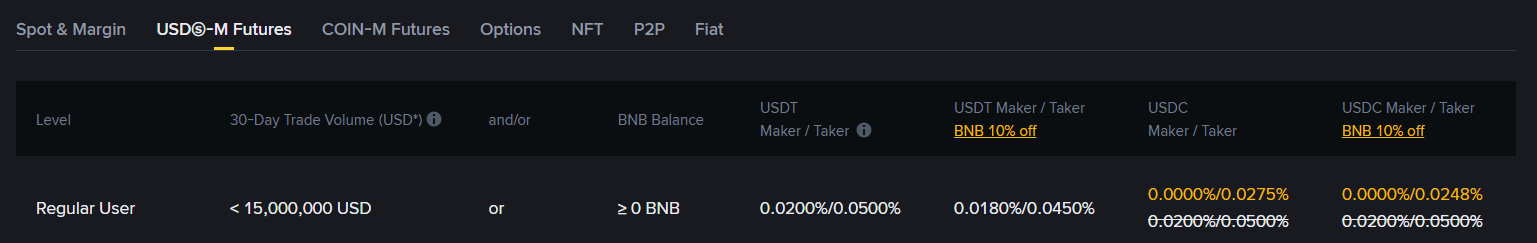
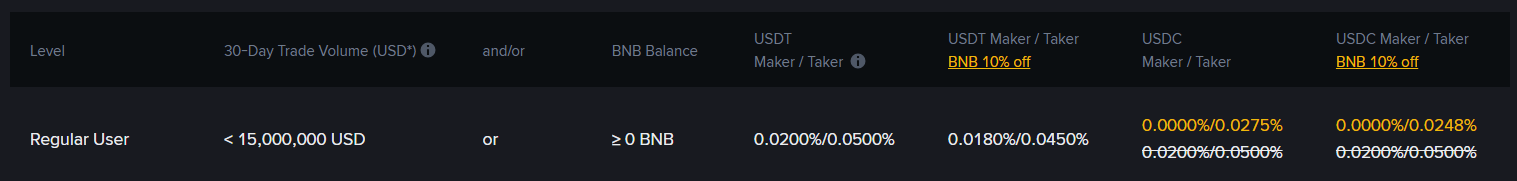

Rozpatrujemy najbardziej pesymistyczną opcję: otwieramy pozycje market, czyli za pozycję płacimy 0.05% prowizji (Taker - liquidity, zabieramy płynność otwierając pozycję po cenie market). Prowizję można zminimalizować płacąc w BNB lub handlując w USDC a nie USDT, ale my robimy opcję negatywną. Prowizja jest płacona przy otwarciu i zamknięciu pozycji, czyli czterokrotnie (otwarcie long x short y, zamknięcie ...).

https://www.binance.com/en/fee/futureFee

### Spread

Spread będzie doliczany do cen aktywów procentowo wg tabeli, w której będzie wyliczony średni spread na danym oknie czasowym dla każdego aktywa.

### Wielkość kapitału

Nie reinwestujemy. Wielkość dostępnego kapitału dla pozycji jest zawsze taka sama, ustalona na initial_cash. "Na boku" obliczamy skumulowane zysk/stratę/prowizje i jeśli przekroczą one initial_cash to kończymy handel. Nie chcemy, aby mniejszy dostępny kapitał po początkowych stratach zaburzał nam dalszy handel. Interesuje nas stricte skuteczność zawierania pozycji w okresie handlowym. W praktyce wyglądałoby to tak, że handlując initial_cash = 100 000 w portfelu znajdowałoby się 200 000: 100 000 jako kapitał przeznaczony na otwieranie pozycji (który nie będzie się zmniejszać pod wpływem strat/kosztów) oraz 100 000 jako kapitał na potencjalne straty/koszty (czyli możemy stracić maksymalnie 100% initial_cash). Nasz system nie ma na celu optymalizacji zarządzania ryzykiem/performance w portfelu - on ma na celu dobre handlowanie pair tradingiem. Ma mieć środowisko do niezależnych decyzji tradingowych, pierwsze straty spowodowane rynkiem nie mogą wpłynąć na to że później będzie podejmować gorsze decyzje przez mniejszy kapitał. Chcemy, aby skupił się na niezależnych decyzjach tradingowych opartych na statystyce, a nie na zarządzaniu portfelem.

### Aktywa

In [1]:
import pandas as pd

pd.read_excel('../data/asset_list.xlsm', dtype={'07.01.2024': 'Int64', '05.10.2025': 'Int64'}).iloc[:15, :2]

,Name,Symbol
0,Bitcoin,BTC
1,Ethereum,ETH
2,BNB,BNB
3,Solana,SOL
4,XRP,XRP
5,Cardano,ADA
6,Avalanche,AVAX
7,Dogecoin,DOGE
8,TRON,TRX
9,Polkadot,DOT


Wybrane wg największej kapitalizacji ze snapshotów z CoinMarketCap.

https://coinmarketcap.com/historical/20240107/

### Xia et al., 2025
- dollar neutral (proporcje 1:1), bez beta-hedge

### Yang & Malik, 2024
#### Okres treningowy:
2 miesiące (wybranie pary oraz Grid Search (ale nie mówią o tym czy na całym okresie treningowym))
- selekcja pary na całym okresie treningowym (TOP1 score liczonego wg korelacji Pearson'a i dwuetapowego testu kointegracji Engle'a-Grangera)
- wybranie parametrów za pomocą Grid Search (nie mówią na jakiej części okresu treningowego była symulacja, a na jakiej warm-up okna z-score, w tabeli maksymalne okno ma 2000 minut (~1,3 dnia), najbardziej optymalne okno wyszło 900, entry threshold 1.9, exit threshold 0.4)
#### Okres testowy:
1 miesiąc handlu parą i parametrami wybranymi w okresie treningowym
- Moving Window Mechanism: obliczają z-score ze spreadu będącego resztą z regresji na cenach co interwał, na podstawie okna
- Nie mówią o tym, czy robią beta-hedge (w jakich proporcjach handlują aktywami, czy handlują na zamrożonych parametrach spreadu z wejścia w pozycję, czy może robią rebalancing aby wyrównać proporcje wg nowej bety co krok...) - można założyć, że nie robią beta-hedge, więc proporcje to 1:1, a handel na rynkowym z-score

### Caldeira & Moura, 2013
#### Okres treningowy:
12 miesięcy (wybranie pary oraz wyliczenie parametrów do spreadu)
- selekcja pary na całym okresie treningowym (ADF - pary które go przeszły mają robiony Engle-Granger test, TOP20 z nich potwierdzają testem Johansena i sortują wg Sharpe Ratio symulacji odpalonej na okresie treningowym)
- z okresu treningowego liczone są parametry spreadu w formie reszty z regresji ln cen
#### Okres testowy:
4 miesiące handlu parametrami wybranymi w okresie treningowym
- parametry spreadu obliczone w okresie treningowym (std, mean, alpha, beta) są stałe na całym okresie testowym; z nich liczą spread i z-score co interwał i podejmują decyzje handlowe (static beta-hedge)
- entry threshold z-score -2/2 std, exit threshold 0 std, stop loss przy 7% straty lub po 50 dniach w pozycji
- dodatkowo filtrem Kalmana sprawdzają, czy strategia na 20 parach jest market neutral: estymowali, jak zmieniała się wrażliwość ich zysków na ruchy indeksu w czasie (oscylowała średnio wokół 0.05, co potwierdzało założenia strategii)

### Gatev et al. 2006
#### Okres treningowy:
6 miesięcy (wybranie par)
- Znormalizowane ceny cumulative returns (zaczynające się od 1)
- MinSSD
- Wyliczenie std z okresu treningowego
#### Okres testowy
1 miesiąc (handel na parze i std z okresu treningowego)
- Stałe entry threshold (2 std) i exit threshold (0 std)
- Handel na spreadzie liczonym jako różnica znormalizowanych cen aktywów w proporcjach 1:1 (dollar hedge)

### U nas
- In-position static beta-hedge with a moving window mechanism of z-score calculating.
#### Wersja podstawowa
- Moving Window Mechanism: parametry spreadu (alfa, beta, mean, std) z których liczony jest spread i z-score, są liczone w każdym kroku na podstawie okna o wielkości n kroków WLICZAJĄC interwał obecny (na którym się znajdujemy).
- Betę liczymy regresją na returns, Z-Score za pomocą bety i surowych cen.
- W momencie otrzymania sygnału otwierana jest pozycja z beta-hedge (proporcje aktywów według bety dla danego kroku). W tym momencie parametry dla spreadu mogą być zamrażane (static-hedge; alfa, beta, mean, std) na okres trwania pozycji. Wtedy dla tej pozycji jest liczony lokalny z-score (dla bety z wejścia), na podstawie którego monitorowana jest pozycja (take profit, stop loss). W przeciwnym wypadku otwieramy pozycję po obliczonej z regresji becie (bez rebalance'owania - te same proporcje przez całą pozycję), ale handlujemy na rynkowym Z-Score (live-hedge).
- Z-Score i Beta mogą być liczone z regresji prices, returns lub log-returns.
$$Y_t = \alpha + \beta X_t + \epsilon_t$$
$$ R_t^Y = \alpha_r + \beta_r R_t^X + \epsilon_t^R $$
$$ r_t^Y = \alpha_\ell + \beta_\ell r_t^X + \epsilon_t^\ell $$
- Beta Hedge może się odbywać na Z-Score z zamrożonych parametrów, lub na Z-Score rynkowym (ale z pozycją otwartą po danej becie).
- Tylko jedna transakcja na krok może zostać wykonana (nie jest możliwe zamknięcie jednej i otwarcie drugie pozycji w jednym momencie).
- Nie możemy zwiększać/redukować istniejącej pozycji. Jeśli otworzymy pozycję x% kapitałem, będzie miała taką wielkość do końca (take profitu/stop lossa).
- Prowizje, zyski i straty są naliczane oddzielnie od kapitału początkowego. Nie chcemy aby początkowe straty wpływały na dalsze decyzje agenta (np. z powodu mniejszego dostępnego kapitału). Chcemy, aby system wypracował politykę do otwierania najlepszych, niezależnych transakcji, nie do zarządzania portfelem i jego ryzykiem. Gdy skumulowane prowizje, zyski i straty są większe niż kapitał początkowy, handel zostaje zakończony (bankructwo).
- Spread liczymy nie jako różnicę znormalizowanych cen (Gatev et al.), tylko jako resztę z regresji liniowej dzięki której wyciągamy betę, która w momencie otwierania pozycji jest naszym parametrem do określania wag aktywów (beta-hedge).
#### Bez RL:
##### Trening:
- Wybieramy treningowe 2 miesiące na wybranym interawale (1m, 3m, 5m).
- Na całym okresie treningowym (2 miesiące) robimy selekcję par.
- Pierwszy miesiąc zapasowy na warm-up (z-score z rolling window), drugi miesiąc na handel który rozpoczyna się zawsze w połowie całego okresu treningowego, w zależności od wybranej wielkości okna (<= wielkośći okresu handlowego) warm-up zaczyna się odpowiednią ilość kroków wcześniej (maksymalnie na początku okresu treningowego).
- Robimy Bayesian Optimization handlu; parametry które dadzą najlepsze wyniki będą używane do handlu w następnych n okresach testowych.
##### Test:
- Przez n miesiące handlujemy na dwóch miesięcznych okresach parametrami z treningu.
- Co miesiąc robimy nową selekcję par i obliczamy nowe parametry dla kolejnego miesiąca.
- Przez n miesięcy handlujemy na parach z selekcji na podstawie poprzednich 2 miesięcy oraz parametrach na podstawie poprzedniego, jednego miesiąca.
- Na podstawie statycznych parametrów (entry threshold, exit threshold, stop loss, beta shift stop) na każdym kroku generowane są sygnały z przestrzeni dyskretnej (-1 dla short leg, 0 dla braku sygnału, 1 dla long leg).
- Na podstawie statycznego parametru position size oraz wygenerowanych sygnałów generujemy trade'y. Bez RL position size powinno być równe 1, co oznacza że do każdej pozycji jest wykorzystywane 100% kapitału.
### Z RL:
- Analogicznie do strategii bez RL, tylko agent będzie podejmować decyzje o wszystkich parametrach poza wielkościami okien iteracyjnie, co interwał wewnątrz funkcji.
- Na każdym kroku agent dynamicznie wybiera parametry (entry threshold, exit threshold, stop loss, beta shift stop) aby wygenerować sygnał.
- Jeśli sygnał jest różny od zera i nie jesteśmy w pozycji, agent decyduje o position size, która definiuje ile % kapitału angażujemy w tę pozycję. Następnie jest ona wykonywana.


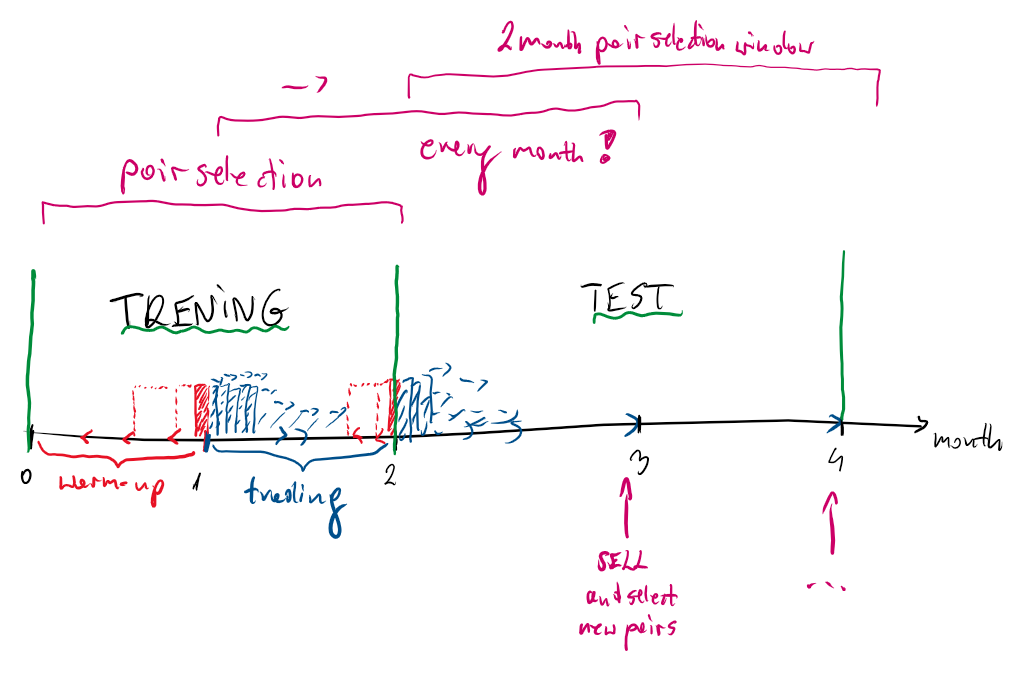